In [ ]:
import sys 
sys.path.append('..')
import os
from utils import convert_coco_to_yolo_polygons 
from datasets import load_dataset
from tqdm.notebook import tqdm

In [ ]:
# Make the train and val directories for images and labels 
def make_yolo_dirs(parent_dir):
    train_dir = os.path.join(parent_dir, "images", "train")
    train_labels = os.path.join(parent_dir, "labels", "train")

    val_dir = os.path.join(parent_dir, "images", "val")
    val_labels = os.path.join(parent_dir, "labels", "val")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(train_labels, exist_ok=True)
    os.makedirs(val_labels, exist_ok=True)
    return train_dir, val_dir

In [ ]:
# Write the yolo formatted label id and polygons for each detection in the image
def get_lines(md, image_width, image_height):
    lines = []

    for row in md:
        label = row.get("label")
        label_id = row.get("label_id")

        # Update label_ids for coco
        if label == 'person':
            label_id = 0
        else:
            label_id + 80

        coco_polygons = row.get("polygons")

        yolo_polygons = convert_coco_to_yolo_polygons(
            coco_polygons, image_width, image_height
        )
        yolo_polygons_str = " ".join([str(coord) for coord in yolo_polygons])
        yolo_line = f"{label_id} {yolo_polygons_str}"
        lines.append(yolo_line)
    return lines

# Save the image and the text file
def write_image_and_text_file(image, image_name, lines, output_dir):
    image_path = os.path.join(output_dir, image_name)

    image_uuid = image_name.split(".")[0]
    text_name = f"{image_uuid}.txt"

    text_output_dir = output_dir.replace("images", "labels")
    text_path = os.path.join(text_output_dir, text_name)

    if image.mode != "RGB":
        image = image.convert("RGB")
        
    image.save(image_path)

    text_file = "\n".join(lines)
    with open(text_path, "w") as f:
        f.write(text_file)

def format_and_write(row, output_dir):
    image = row.get('image')
    width = 1024
    height = 1024
    md = row.get('mask_metadata')
    if md:
        image_name = row.get('image_id')
        lines = get_lines(md, width, height)
        write_image_and_text_file(image, image_name, lines, output_dir)

repo_id = "jordandavis/fashion_people_detections"
workers = os.cpu_count()
ds = load_dataset(repo_id, split='train', trust_remote_code=True, num_proc=workers)

ds = ds.train_test_split(train_size=0.9)
train = ds["train"]
val = ds["test"]

parent_dir = "datasets/fashion_people_detection"

# Make directories
train_dir, val_dir = make_yolo_dirs(parent_dir)

for dataset, output_dir in zip([train, val], [train_dir, val_dir]):
    
    iterable = tqdm(map(format_and_write, dataset, [output_dir]*len(dataset)), total=len(dataset))
    for _ in iterable:
        pass


In [ ]:
repo_id = "jordandavis/fashion_people_detections"
workers = os.cpu_count()
ds = load_dataset(repo_id, split='train', trust_remote_code=True, num_proc=workers)

In [ ]:
from utils import convert_coco_polygons_to_mask, overlay_mask
from PIL import Image 


In [ ]:
def convert_coco_to_yolo_polygons(coco_polygons, image_width, image_height):
    """
    Converts COCO style polygons to a normalized YOLO style format, outputting a single list
    of normalized coordinates representing the perimeter of the segmentation.

    Parameters:
    - coco_polygons: List of polygons, each represented as a flat list of points (x1, y1, x2, y2, ..., xn, yn).
    - image_width: The width of the original image.
    - image_height: The height of the original image.

    Returns:
    - Single list of normalized coordinates in the format [x1, y1, x2, y2, ..., xn, yn] for all polygons concatenated.
    """
    yolo_coordinates = []
    for polygon in coco_polygons:
        for i in range(0, len(polygon), 2):
            x_normalized = polygon[i] / image_width
            y_normalized = polygon[i + 1] / image_height
            yolo_coordinates.extend([x_normalized, y_normalized])

    return yolo_coordinates


In [17]:
def convert_yolo_to_coco_polygons(yolo_coordinates, image_width, image_height):
    """
    Converts YOLO style normalized coordinates back to COCO style polygons.

    Parameters:
    - yolo_coordinates: Single list of normalized coordinates in the format [x1, y1, x2, y2, ..., xn, yn].
    - image_width: The width of the original image.
    - image_height: The height of the original image.

    Returns:
    - List of lists where each inner list represents a polygon with its original pixel coordinates (x1, y1, x2, y2, ..., xn, yn).
    """
    # Since YOLO coordinates are all in one list, assume that each sequence of points forms one polygon.
    # The provided example doesn't specify how polygons are separated, so this example assumes a single polygon.
    coco_polygon = []
    for i in range(0, len(yolo_coordinates), 2):
        x_original = yolo_coordinates[i] * image_width
        y_original = yolo_coordinates[i + 1] * image_height
        coco_polygon.extend([int(round(x_original)), int(round(y_original))])

    # In a more complex scenario where multiple polygons are needed, additional logic would be required to separate them.
    return [coco_polygon]


In [18]:
yolo_polygons = convert_coco_to_yolo_polygons(polygons, 1024, 1024)
coco_polygons = convert_yolo_to_coco_polygons(yolo_polygons, 1024, 1024)
print(yolo_polygons)

[0.6396484375, 0.0, 0.6396484375, 0.0029296875, 0.638671875, 0.00390625, 0.638671875, 0.0068359375, 0.6376953125, 0.0078125, 0.6376953125, 0.0107421875, 0.63671875, 0.01171875, 0.63671875, 0.013671875, 0.6357421875, 0.0146484375, 0.6357421875, 0.017578125, 0.634765625, 0.0185546875, 0.634765625, 0.0224609375, 0.6337890625, 0.0234375, 0.6337890625, 0.0322265625, 0.6328125, 0.033203125, 0.6328125, 0.056640625, 0.6337890625, 0.0576171875, 0.6337890625, 0.0615234375, 0.634765625, 0.0615234375, 0.634765625, 0.060546875, 0.63671875, 0.05859375, 0.63671875, 0.0576171875, 0.638671875, 0.0556640625, 0.638671875, 0.052734375, 0.6396484375, 0.0517578125, 0.6396484375, 0.05078125, 0.6416015625, 0.048828125, 0.6416015625, 0.046875, 0.642578125, 0.0458984375, 0.642578125, 0.044921875, 0.6435546875, 0.0439453125, 0.6435546875, 0.04296875, 0.64453125, 0.0419921875, 0.64453125, 0.041015625, 0.6455078125, 0.0400390625, 0.6455078125, 0.0390625, 0.646484375, 0.0380859375, 0.646484375, 0.0361328125, 0.6474

hair


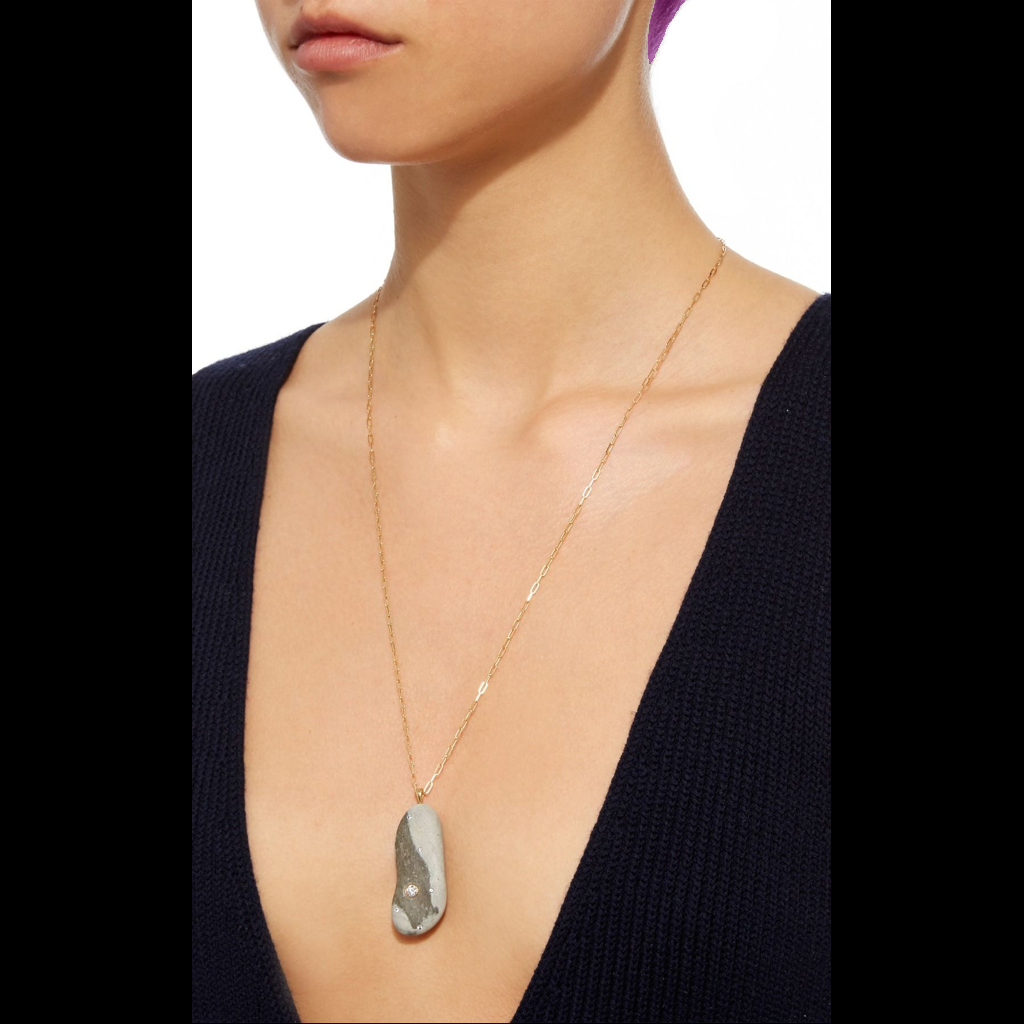

In [19]:
row = 100
mask_row = 1
image = ds[row]['image']
label = ds[row]['mask_metadata'][mask_row]['label']
polygons = ds[row]['mask_metadata'][mask_row]['polygons']
mask = convert_coco_polygons_to_mask(coco_polygons, 1024, 1024)
mask_image = Image.fromarray(mask)
print(label)
overlay_mask(image, mask_image)

In [ ]:
def convert_yolo_to_coco_polygons(yolo_coordinates, image_width, image_height):
    """
    Converts YOLO style normalized coordinates back to COCO style polygons.

    Parameters:
    - yolo_coordinates: Single list of normalized coordinates in the format [x1, y1, x2, y2, ..., xn, yn].
    - image_width: The width of the original image.
    - image_height: The height of the original image.

    Returns:
    - List of lists where each inner list represents a polygon with its original pixel coordinates (x1, y1, x2, y2, ..., xn, yn).
    """
    # Since YOLO coordinates are all in one list, assume that each sequence of points forms one polygon.
    # The provided example doesn't specify how polygons are separated, so this example assumes a single polygon.
    coco_polygon = []
    for i in range(0, len(yolo_coordinates), 2):
        x_original = yolo_coordinates[i] * image_width
        y_original = yolo_coordinates[i + 1] * image_height
        coco_polygon.extend([int(round(x_original)), int(round(y_original))])

    # In a more complex scenario where multiple polygons are needed, additional logic would be required to separate them.
    return [coco_polygon]


convert_yolo_to_coco_polygons()